# ベイズ統計の枠組みと解釈について

以下の黒木さんのnotebook(参考文献[[1]](#参考文献))を参考にベイズ統計についての学習用のノートブック。

他には、渡辺澄夫さんの著書などを参照している。（そのうち参考にまとめる）

## 目次

---

* [1. 確率論入門](#確率論入門)

* [参考文献](#参考文献)

In [4]:
using Base64
displayfile(mime, file; tag="img") = open(file) do f
    display("text/html", """<$tag src="data:$mime;base64,$(base64encode(f))">""")
end

using Distributions
using Statistics
using StatsBase

using StatsPlots
using Plots
default(size=(400, 250), titlefontsize=10)
pyplot(fmt=:svg)
PyPlot_clf() = if backend() == Plots.PyPlotBackend() PyPlot.clf() end

using Random
using QuadGK
using SpecialFunctions

ArgumentError: ArgumentError: Package SpecialFunctions not found in current path:
- Run `import Pkg; Pkg.add("SpecialFunctions")` to install the SpecialFunctions package.


## 確率論入門

---

TBD

## 統計学入門

### 統計学の基本問題

**基本問題**　：　サンプル$X_1, X_2, \cdots, X_n$のみから母集団の分布$q(x)$についてどれだけ推測できるか、またどのような方法が考えられるか？

e.g.)　未知の母集団分布q(x)のサイズn=50のサンプル
        1.1, 1.45, 0.93, 2.01, 0.13, 1.78, 1.07, 0.75, 0.48, 0.64, 
        0.81, 1.13, 0.89, 1.39, 0.69, 0.57, 3.22, 1.18, 2.03, 0.85, 
        1.08, 0.96, 1.1, 0.81, 1.19, 1.09, 1.51, 1.01, 0.54, 0.84, 
        1.06, 0.33, 1.14, 0.67, 1.57, 0.88, 0.48, 0.78, 0.38, 0.82, 
        0.53, 0.52, 1.18, 0.67, 2.01, 1.14, 0.71, 0.69, 1.24, 0.72 
     が得られたとする。このサンプルのヒストグラムを表示する

In [5]:
?histogram

search: histogram Histogram histogram! histogram2d histogram2d! ea_histogram



```
histogram(x)
histogram!(x)
```

Plot a histogram.

# Arguments

  * `x`: AbstractVector of values to be binned
  * `bins`: Integer, NTuple{2,Integer}, AbstractVector or          Symbol. Default is :auto (the Freedman-Diaconis rule). For          histogram-types, defines the approximate number of bins to aim for,          or the auto-binning algorithm to use (:sturges,          :sqrt, :rice, :scott or :fd). For fine-grained control          pass a Vector of break values, e.g. `range(minimum(x),          stop = maximum(x), length = 25)`
  * `weights`: Vector of weights for the values in `x`, for weighted bin counts
  * `normalize`: Bool or Symbol. Histogram normalization mode.               Possible values are: false/:none (no normalization,               default), true/:pdf (normalize to a discrete               Probability Density Function, where the total area of the               bins is 1), :probability (bin heights sum to 1)               and :density (the area of each bin, rather than               the height, is equal to the counts - useful for               uneven bin sizes).
  * `bar_position`: Symbol.  Choose from `:overlay` (default),                  `:stack`.  (warning: May not be implemented fully)
  * `bar_width`: nothing or Number. Width of bars in data               coordinates. When nothing, chooses based on x (or y when               `orientation = :h`).
  * `bar_edges`: Bool.  Align bars to edges (true), or centers               (the default)?
  * `orientation`: Symbol.  Horizontal or vertical orientation                 for bar types.  Values `:h`, `:hor`,                 `:horizontal` correspond to horizontal (sideways,                 anchored to y-axis), and `:v`, `:vert`, and                 `:vertical` correspond to vertical (the default).

# Example

```julia-repl
julia> histogram([1,2,1,1,4,3,8],bins=0:8)
```


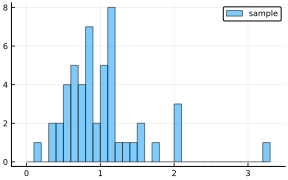

In [6]:
X = [
        1.1, 1.45, 0.93, 2.01, 0.13, 1.78, 1.07, 0.75, 0.48, 0.64, 
        0.81, 1.13, 0.89, 1.39, 0.69, 0.57, 3.22, 1.18, 2.03, 0.85, 
        1.08, 0.96, 1.1, 0.81, 1.19, 1.09, 1.51, 1.01, 0.54, 0.84, 
        1.06, 0.33, 1.14, 0.67, 1.57, 0.88, 0.48, 0.78, 0.38, 0.82, 
        0.53, 0.52, 1.18, 0.67, 2.01, 1.14, 0.71, 0.69, 1.24, 0.72 
]

histogram(X; bins=range(0,3.3,step=0.1), alpha=0.5, label="sample")

In [7]:
μ = mean(X)
σ = var(X, corrected=false) # corrected=trueのとき、不偏分散を計算している。
println("mean : $μ , var : $σ")

mean : 1.015 , var : 0.27602899999999997


* ($\alpha$, $\theta$) = ($4, \frac{1}{4}$)のガンマ分布を母集団分布とするサンプル（小数点以下２桁まで丸てる）

* 上記の母集団分布の平均と分散はそれぞれ、平均1, 分散0.25となる

* histogramで表示したサンプルの平均と分散はそれぞれ、平均1.015, 分散は0.276程度となる

上記ヒストグラムと、正規分布を重ねてプロットする。

In [8]:
function fit_mle_and_plot(X, model, model_str; x=range(0,3.3,length=200))
    dist_mle = fit_mle(model, X)
    f(x) = pdf(dist_mle, x)
    AIC = -2sum(logpdf.(dist_mle, X)) + 2length(params(dist_mle))
    histogram(
        X; bins=range(0,3.3,step=0.1), alpha=0.5, ylim=(0, 1.7), label="sample", norm=true
    )
    plot!(
        x, pdf.(Gamma(4, 0.25), x), label="true population distribution.",
        lw=1.5, ls=:dash, color=:black
    )
    plot!(
        x, f.(x), label="$model_str dist approx", lw=2, color=:red
    )
    title!(" $model_str dist model \n AIC = $(round(AIC, digits=2))")
end

fit_mle_and_plot (generic function with 1 method)

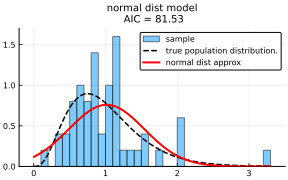

In [9]:
fit_mle_and_plot(X, Normal, "normal")

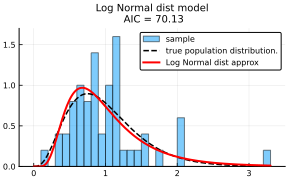

In [10]:
fit_mle_and_plot(X, LogNormal, "Log Normal")

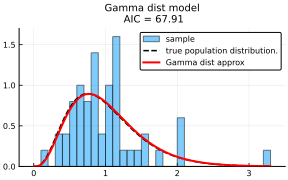

In [11]:
fit_mle_and_plot(X, Gamma, "Gamma")

### 尤度

モデルのサンプルへの確率的な適合度だとみなすのが正しい。

$X_1, X_2, \cdots, X_n$は未知の母集団分布$q(x)$に従うi.i.dなサンプルである。このとき,$(X_1, X_2, \cdots, X_n)$の分布は確率密度関数

$$
(x_1, \dots, x_n) \mapsto q(x_1)\cdots q(x_n)
$$

をもつ。

パラメータ$w$の関数

$$
w \mapsto p(X_1|w)p(X_2|w)\cdots p(X_n|w)
$$

をサンプル$X_1, \dots, X_n$に関するモデル$p(x|w)$の**尤度**の関数と呼ぶ。

意味するところは、単に

「モデル$p(x|w)$にしたがう独立試行によって偶然サンプル$X_1, \cdots , X_n$が生成される確率（密度）」

つまるところは、モデルのサンプルへの確率的な適合度。。

### 最尤法

大数の法則より、尤度関数の対数の$-\frac{1}{n}$倍の$L_n(w)$は$n \rightarrow \infty$でモデルp(x|w)の汎化誤差G(w)に収束する。：

$$
L_n(w) = \frac{1}{n}\displaystyle{\sum_{i=1}^{n}}(-logp(X_k|w)) \rightarrow G(w) = \int q(x)(-logp(x|w))dx
$$

すなわち、尤度関数の対数の -$\frac{1}{n}$ 倍$L_n(w)$は汎化誤差$G(w)$の一致推定量になっている。

欲しいのは汎化誤差を最小化するw=$w_0$である。汎化誤差を最小化する$w_0$を求める代わりに$L_n(w)$を最小化してパラメータw=$\hat{w}$を決めて予測分布を$p(x|\hat{w})$とする方法を**最尤法**という

### 例：正規分布モデルによる最尤法

モデルp(x|w)が以下の正規分布モデルの場合を考える。

$$
p(x|\mu, sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\text{exp}\displaystyle{\{\frac{(x-\mu)^2}{2\sigma^2}\}}
$$

このとき、母集団分布q(x)の平均と分散をそれぞれ$\mu_0,\space,\sigma_0^2$と書く。
またサンプル$X_1, \cdots, X_n$の平均と分散をそれぞれ$\bar{X}, S^2$と書く。
このとき、それぞれは以下の式で表す。

$$
\begin{align}
\mu_0 &= \int q(x)xdx \\
\sigma_0^2 &= \int q(x)(x-\mu_0)^2dx = \int q(x)x^2dx - \mu_0^2 \\
\bar{X} &= \frac{1}{n}\displaystyle{\sum_{k=1}^{n}}X_k \\
S^2 &= \frac{1}{n}\displaystyle{\sum_{k=1}^{n}}(X_k - \bar{X})^2 = \frac{1}{n}\displaystyle{\sum_{k=1}^{n}}X_k^2 - \bar{X}^2 \\
\end{align}
$$

このとき、汎化誤差と対数尤度関数の$-\frac{1}{n}$倍はそれぞれ以下のように計算される。



### 最尤法と物理の類似

対数尤度関数の-1倍$nL_n(w)$は物理におけるハミルトニアンの類似物であり、最尤法の解$w=\hat{w}$は基底状態の類似物だとみなせる

ただし、対数尤度関数の-1倍$nL_n(w)$の中には母集団分布に従う確率変数達$X_k$が含まれており、ランダムに決まるハミルトニアンと見なさなければならない

統計学では$n \rightarrow \infty$で推定値が最良値に近づいて欲しいという要求がある。統計学は$n \rightarrow \infty$における各種統計量の漸近挙動を調べることを**漸近論**

Bayes統計では等確率の原理を仮定しないので事前分布$\varphi(w)$の自由度が発生する。通常のBayes統計は逆温度が$\beta=1$の場合に相当する。


### 尤度関数は推定の収束の様子の情報を持っている

サンプルサイズを大きくすると、尤度関数

$$
\displaystyle{\Phi_{k=1}^{n}} p(X_k|w) = exp(-nL_n(w))
$$

のグラフが漸近的に単峰型になり、サンプルサイズを大きくするにつれて尤度関数の山型のグラフの裾野のサイズが小さくなっていくことが知られている。山型の尤度関数のグラフの台の小ささは「推定の収束し具合」を表していると解釈できる。










 11.126576 seconds (3.55 M allocations: 155.024 MiB, 0.53% gc time)
  0.516175 seconds (530 allocations: 28.984 KiB)


┌ Info: Saved animation to 
│   fn = /Users/chibadaimare/Documents/mathematical/math/statistics/statistics/julia_stats/notebooks/images/lik_normal_for_gamma_sample.gif
└ @ Plots /Users/chibadaimare/.julia/packages/Plots/cc8wh/src/animation.jl:98



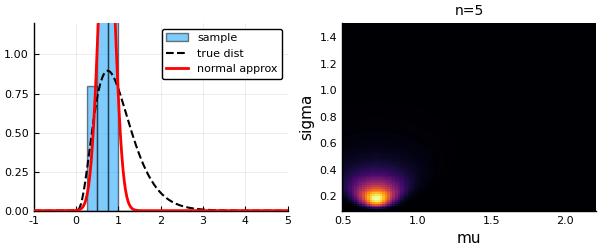

In [20]:
# 尤度関数のプロット

Random.seed!(42)

dist_gamma = Gamma(4.0, 0.25)
N = 200
XX = rand(dist_gamma, N)

ns = [5;5;5;5;5:10; 12:2:20; 25:5:N; N;N;N;N;N]

@time anim = @animate for n in ns
    X = @view XX[1:n]
    x = range(-1, 5, length=200)
    
    dist_normal_approx_gamma = fit_mle(Normal, X)
    P1 = histogram(X; normed=true, bins=range(0, 5, step=0.25), alpha=0.5, label="sample")
    plot!(x, pdf.(dist_gamma, x); label="true dist", lw=1.5, ls=:dash, color=:black)
    plot!(x, pdf.(dist_normal_approx_gamma, x); label="normal approx", lw=2, color=:red)
    plot!(legend=true, xlim=(-1, 5), ylim=(0, 1.2))
    
    loglik(μ, σ) = sum(logpdf(Normal(μ, σ), x) for x in X)
    μ = range(0.5, 2.2, length=100)
    σ = range(0.1, 1.5, length=100)
    P2 = heatmap(
        μ, σ, exp.(loglik.(μ', σ)); xlabel="mu", ylabel="sigma",
        size=(300, 320), colorbar=false, title="n=$n"
    )
    plot(P1, P2, size=(600, 250))
end
PyPlot_clf()
@time gif(anim, "images/lik_normal_for_gamma_sample.gif", fps=5)
sleep(0.1)
displayfile("image/gif", "images/lik_normal_for_gamma_sample.gif")

 14.844876 seconds (6.89 M allocations: 213.206 MiB, 0.55% gc time)
  0.488751 seconds (529 allocations: 28.656 KiB)


┌ Info: Saved animation to 
│   fn = /Users/chibadaimare/Documents/mathematical/math/statistics/statistics/julia_stats/notebooks/images/lik_gamma_for_gamma_sample.gif
└ @ Plots /Users/chibadaimare/.julia/packages/Plots/cc8wh/src/animation.jl:98



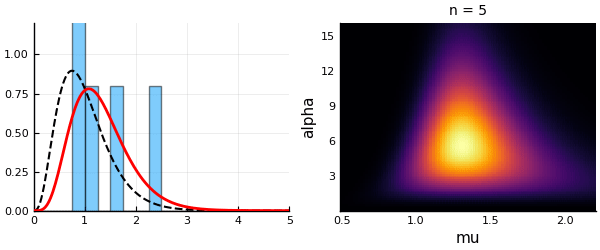

In [19]:
# 尤度函数のプロット

Random.seed!(37346491)

dist_gamma = Gamma(4.0, 0.25)
N = 200
XX = rand(dist_gamma, N)

ns = [5;5;5;5;5; 5:10; 12:2:20; 25:5:N; N;N;N;N;N]
@time anim = @animate for n in ns
    X = @view XX[1:n]
    x = range(0, 5, length=200)

    dist_gamma_approx_gamma = fit_mle(Gamma, X)
    P1 = histogram(X; normed=true, bins=range(0, 5, step=0.25), alpha=0.5, label="sample")
    plot!(x, pdf.(dist_gamma, x); label="true dist", lw=1.5, ls=:dash, color=:black)
    plot!(x, pdf.(dist_gamma_approx_gamma, x); label="Gamma approx", lw=2, color=:red)
    plot!(legend=false, xlim=(0, 5), ylim=(0, 1.2))

    loglik(μ, α) = sum(logpdf(Gamma(α, μ/α), x) for x in X)
    μ = range(0.5, 2.2, length=100)
    α = range(0.1, 16, length=100)
    P2 = heatmap(μ, α, exp.(loglik.(μ', α)); xlabel="mu", ylabel="alpha",
        size=(300, 320), colorbar=false, title="n = $n")
    
    plot(P1, P2, size=(600, 250))
end
PyPlot_clf()
@time gif(anim, "images/lik_gamma_for_gamma_sample.gif", fps=5)
sleep(0.1)
displayfile("image/gif", "images/lik_gamma_for_gamma_sample.gif")

## 参考文献

---

* [1] [ベイズ統計の枠組みと解釈について (黒木　玄) ](https://nbviewer.jupyter.org/github/genkuroki/Statistics/blob/master/Introduction%20to%20Bayesian%20Statistics.ipynb#%E3%81%8A%E3%81%99%E3%81%99%E3%82%81%E3%81%AE%E3%83%99%E3%82%A4%E3%82%BA%E7%B5%B1%E8%A8%88%E5%85%A5%E9%96%80)